## Robust Resource and Error Handling

### Exceptions
* Errors are almost always communicated using Exceptions
* overly-broad exception handlers can catch exceptions you don't want to catch, such as
  + KeyboardInterrupt (when you press ctr-c)
  + NameError (when you use the incorrect variable or function names)
* Generally, you should specify an exception type in except statements
* Exceptions are arranged into an inheritance hierarchy
  + this facilitates catching exceptions by their base classes

#### Exception Hierarchies
* we can trace the exception hierarchy use dunder mro attribute
* one example is IndexError and KeyError, both refer to 'no such element error'
  + from their mro, we see they both inherit from LookupError
  + we can catch both of them by catching LookupError
* the following is an hierarchy tree
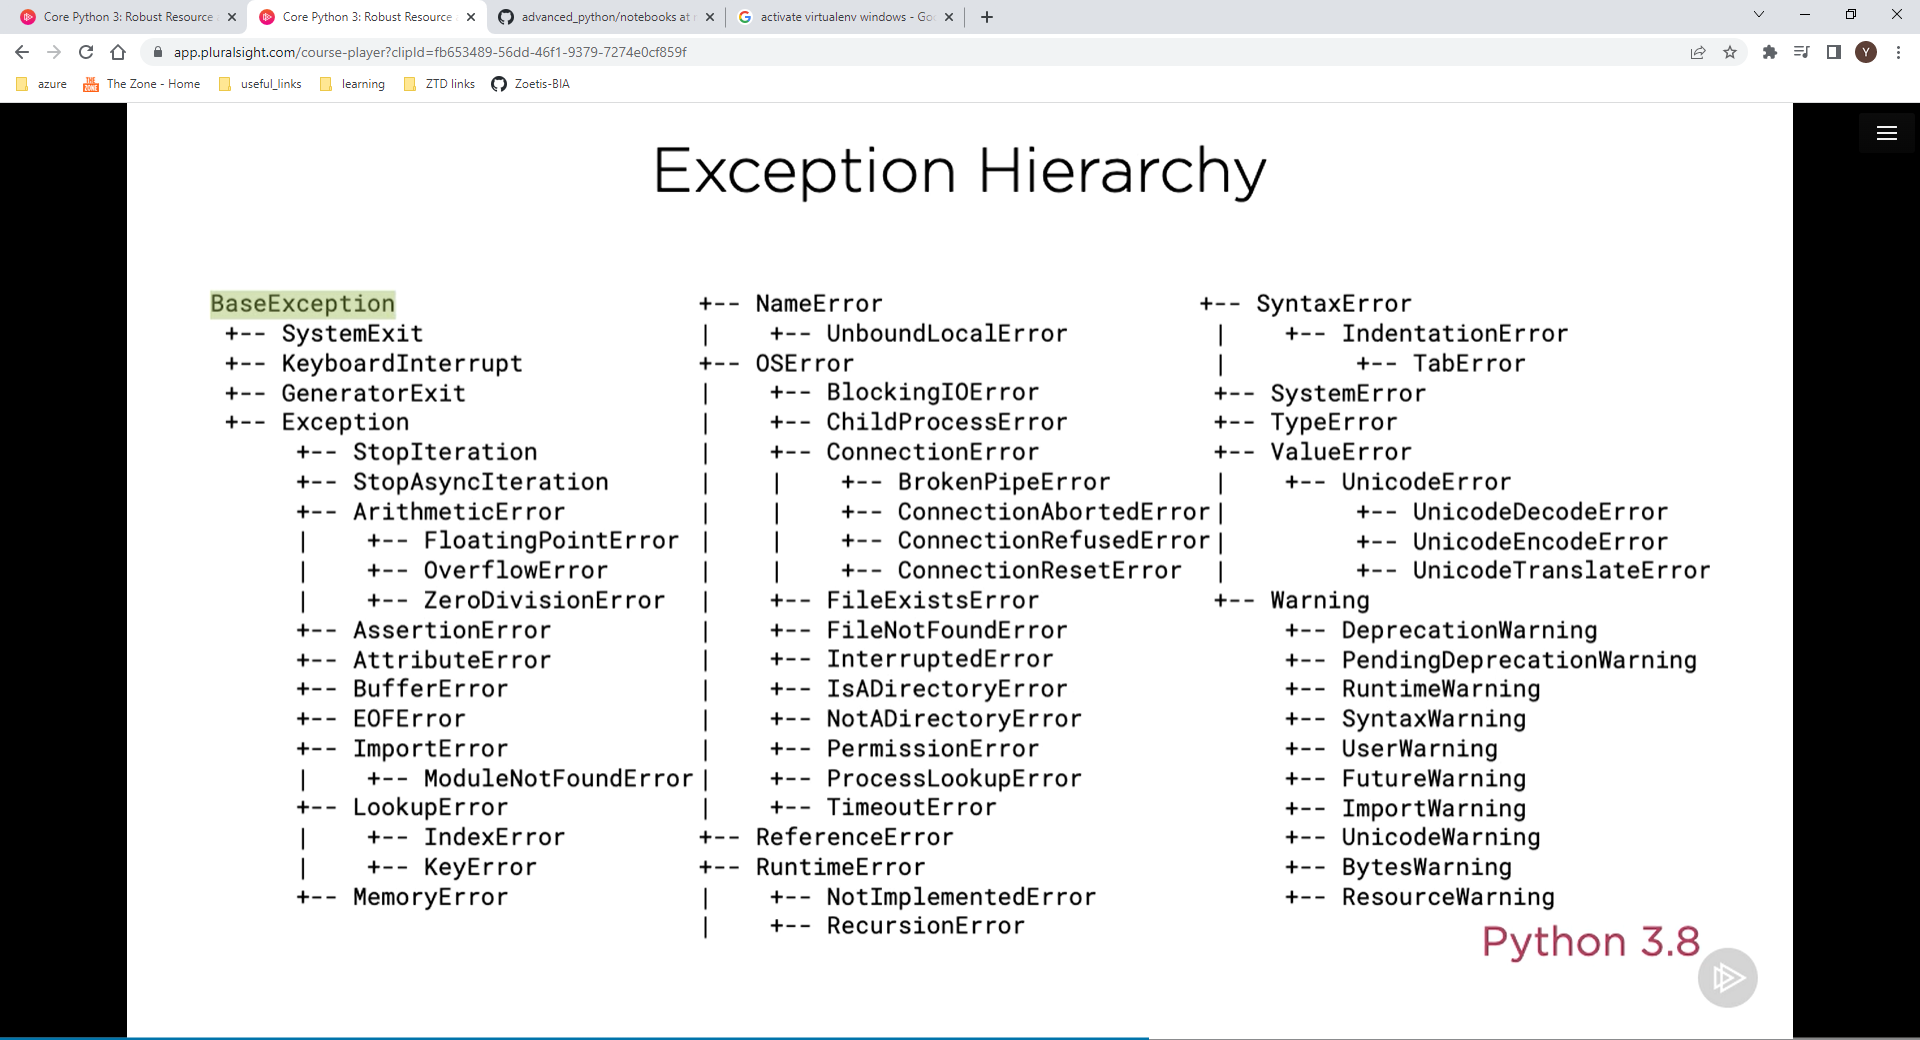
* Non-system-exiting exceptions inherit from Exception
* Errors raleted to programming and syntax need to be handled as specific as possible
* OSError tells something has gone wrong with a filesystem operation
  + often not necessary to know the details of exactly what went wrong
  + even when you catch the general exception type, the details are still available from exception payloads
  

In [2]:
print(IndexError.__mro__)
print(KeyError.__mro__)

(<class 'IndexError'>, <class 'LookupError'>, <class 'Exception'>, <class 'BaseException'>, <class 'object'>)
(<class 'KeyError'>, <class 'LookupError'>, <class 'Exception'>, <class 'BaseException'>, <class 'object'>)


#### Exception Payloads
* Exception can carry payload data
  + contains diagnostic information about the cause of exception
* Most exceptions accept a single string in their construction call
* The most common exception raised is ValueError (shown in code example)
  + used for argument validation guard clauses near the beginning of the function
* most exception payloads are strings containing a helpful message
  + we can retrieve the message from the args attribute of the exception
    + notice that args attribute is a tuple
  + another way to get message is to use the string representation of the exception object
* although you can pass multiple string args to the constructor of exceptions, but it is recommended that you only pass one single string argument 
* specific exception class may provide additional specific name attributes, such as UnicodeEror has encoding, reason, object, start and end attributes for more information about that exception

In [8]:
def median(iterable):
    items = sorted(iterable)
    if len(items) == 0:
        raise ValueError("median() arg is an empty series")
        
    median_index = (len(items) -1) //2
    if len(items) % 2 != 0:
        return items[median_index]
    return (items[median_index] + items[median_index + 1]) //2

def invoker():
    try:
        median([])
    except ValueError as e:
        print("Payload", e.args) 
        print("Payload repr:", repr(e))
        print("Payload str:", str(e)) 


# raises ValueError if an empty list is passed
invoker()              

Payload ('median() arg is an empty series',)
Payload repr: ValueError('median() arg is an empty series')
Payload str: median() arg is an empty series


#### User-defined exceptions
* you can define your own exceptions

In [9]:
import math

class TriangleError(Exception):
    
    def __init__(self, text, sides):
        super().__init__(text)
        self._sides = tuple(sides)
        
    @property
    def sides(self):
        return self._sides
    
    def __str__(self):
        return "'{}' for sides{}".format(self.args[0], self._sides)
    
    def __repr__(self):
        return "TriangleError({!r}, {!r})".format(self.args[0], self._sides)
    
def triangle_area(a, b, c):
    sides = sorted((a, b, c))
    if sides[2] > sides[0] +  sides[1]:
        raise TriangleError("Illegal Triangle", sides)
        
    p = (a + b + c) /2
    a = math.sqrt(p * (p - a) * (p - b) * (p - c))
    return a

In [12]:
try:
    triangle_area(3, 4, 10)
except TriangleError as e:
    print(e.args[0])
    print(e.sides)

Illegal Triangle
(3, 4, 10)


#### Exception Chaining
* Python only raise one exception at a time
* explicit exception chaining
  + program explicitly raises one exception in response to another
* implicit exception chaining
  + occurs when an exception is raised incidentally (at the same time) during processing of anthoer
  + python automatically chains any exception raised during the handling of another
  + the original exception is stored on the \_\_context\_\_ attribute of the second  

#### Implicity exception code example
* in the following code, there are two errors raised.
* the first exception was raised when executing triangle area calcuation
* when this exception is handled by except block, the second error of using sys.stdin was raised
* in this example, the TriangleError exception is attached to the dunder context attribute of UnsupportedOperation exception object
* since we don't need to do anything to chain these exceptions, this is call implicit chaining

In [15]:
import sys
def invoke():
    try:
        a = triangle_area(3, 4, 10)
        print(a)
    except TriangleError as e:
        print(e, file=sys.stdin)

invoke()

In [18]:
import sys
import io
def invoke():
    try:
        a = triangle_area(3, 4, 10)
        print(a)
    except TriangleError as e:
        try: 
            print(e, file=sys.stdin)
        except io.UnsupportedOperation as f:
            print(e)
            print(f)
            print(f.__context__ is e)

invoke()

'Illegal Triangle' for sides(3, 4, 10)
not writable
True


#### Explicit chaining code example
* delibrately associate an exception with a new exception at the point of raising the latter
* This is done by translating one exception to another
* in the following code example, the InclinationError was raised from ZeroDivisionError
  + in another word, the ZeroDivisionError was translated to InclinationError using 'from e' clause
  + different from implicit chaining, the old exception is stored in \_\_cause\_\_ attribute of the new exception
* when translating exceptions, consider whether to use explicit exception chaining for easy debugging and diagnositic purpose  

In [20]:
import math

class InclinationError(Exception):
    pass

def inclination(dx, dy):
    try:
        return math.degrees(math.atan(dy/dx))
    except ZeroDivisionError as e:
        raise InclinationError("Slope cannot be vertical") from e
try:
    inclination(0, 5) 
except InclinationError as e:
    print(e)
    print(e.__cause__)

Slope cannot be vertical
division by zero


#### Tracebacks
* records of the function call stack printed by interpreter when an exception is unhandled and the program exits
* every exception object has a \_\_traceback\_\_ attribute that holds a reference to its traceback object associated with that exception, as shown in the following code example
* traceback module provide by python standlibrary containing functions for working with traceback objects
  + we used print_tb function from this module
* there are many more functions in the traceback module
  + format_tb() can render a traceback to a string
* you should only render a trackback within the scope of an except block, rather than save it for later use
  + this is because tracebacks contain references to their stack frames and, thus, o all of the locals in those frames
  + since the transitive closure over the stack frames can use a lot of memory, and it won't be garbage collected until the traceback is release
  + for long term storage, render tracebacks into a different, more concise from suited to your needs

In [25]:
from traceback import print_tb

def invoke():
    try:
        inclination(0, 5)
    except InclinationError as e:
        print(e.__traceback__)
        print_tb(e.__traceback__)
    print("Finished")   
    
invoke()    

Finished


  File "C:\Users\HuangY07\AppData\Local\Temp\1\ipykernel_840\1270178315.py", line 5, in invoke
    inclination(0, 5)
  File "C:\Users\HuangY07\AppData\Local\Temp\1\ipykernel_840\2155122589.py", line 10, in inclination
    raise InclinationError("Slope cannot be vertical") from e


### Assertions
* key tool for ensuring that our implementation works as expected
* format of assertion syntax:        
  `assert condition [, message]`
    + condition is a boolean expression
      + if assertion is False, AssertionError will be raised, if message is supplied, it will be used in exception payload
    + message is an optional string or error message
* in the code example below, the AssertionError was handled just like ane Error exceptions
* the purpose of Assertions is to give you a convenient means to monitor program invariants
* program invariants are conditions which should always be true for your program
* a failing assertion points to a programming error
* if an assertion condition is true, it will not have any effect, the program will move to the next statement
* assertions are best used to document conditions your program takes for granted
  +  a name being bound to an object rather than None
  + a list being sorted
* there are good and bad places to use assertions
  + in if else block if we are sure some branch conditions should only include certain conditions, we should use assert. The advantage is that later on when the code is modified, we can quickly find the invariant is broken due to the change, and fix the issue
* use assertions to check that your implementation is correct
* do not use assertions to validate arguments, which should be done using ValueError check
* use python -O to disable assertions if performance concerns demand it
* running in production with assertions helps flush out problems in your code
* make sure the side effect of assertion is minimized to reduce the different results from turning on and off the assertion

In [26]:
assert False, "The condition was false"

AssertionError: The condition was false

#### using Assertions for class invariants
* we can define a private method to check the conditions are satisfied. This method returns a boolean value
* we then embed an assert statement of this method in other methods that will make changes to the class object to ensure the change we make will comply with the invariant conditions

#### Postcondition and assertion
* use assertion to ensure the function returns what is expected
* we can use assert all(), any() etc. to check all or any conditions are satisfied

### Context Manager
* A context manager is an object designed to be used in a with statement
  + when a with statement is executed, the expression part of the statement (the part following the with keyword) evaluates to a value. This value must be a context manager
  + the underlying mechanics of the with statement use this value in specific ways to implement the semantics of the with statement 
* A context manager implements two methods:
  + The first is called before entering the with-block
  + The second is called after exiting the with-block even if the block exits with an exception
  + in another word, a context manager represents code that runs before and after the with block
  + these two methods are referred as enter and exit, and are called everytime the with statement is executed, no matter how the with block terminates
* to summarize, context manager is an object that ensures that resources are properly and automatically handled
  + the "enter" method ensures that the resource is ready for use
  + the "exit" method ensures that the resource is cleaned up
* an example is 
```python
with open("file_name", 'W') as f:
    f.write('the secret password is 12345')
```
  + The with-statement ensures that the file is properly closed, even when there is an exception in the with-block

#### Context manager protocol
* A context manager needs to support a specific protocol
* it must implement the following two methods:
  + \_\_enter\_\_()
  + \_\_exit\_\_()
* how does with statement work?
  + the expression in the with statement must be evaluated as a context manager
  + this context manager must implements both dunder enter and dunder exit methods
  + the with statement will then call dunder enter() method without any arguments
    + if dunder enter() throws an exception, execution will never enter with block and with statement is done
    + if dunder enter() execute successfully, it could return a value. If the with statement include an as clause, the returned value is bound to the name in the as clause. Otherwise, this returned value is discarded
  + the with block itself is executed, which can terminate in one of two fundamental ways:
    + raise an exception
    + execute to the end of the block (normal termination)
  + dunder exit() is executed. If an exception is raised, exception information is passed to dunder exit(), which can do different things depending on whether an exception has been raised   
    
    
```python
# it is the value of expression.__enter__()  
# that is bound to x, not the value of expression
with expression as x:
    body
```

* the following code example showed a simple context manager 
  + with statement executes to construct a LoggingContextManager instance object
  + the dunder enter() method of this object is executed
  + the return value of this method, which is the string of "You are in a with-block" is assigned to x
  + the value of x is printed in the with block
  + after executing with block, \_\_exit\_\_() is executed

In [28]:
# version 1, an implementation of a simple context manager
class LoggingContextManager:
    def __enter__(self):
        print('LoggingContextManager.__enter__()')
        return "You are in a with-block"
    
    def __exit__(self, exc_type, exc_val, exc_tb):
        print('LoggingContextManager.__exit__({}, {}, {})'.format(
              exc_type, exc_val, exc_tb))
        return
    
with LoggingContextManager() as x:
    print(x)

LoggingContextManager.__enter__()
You are in a with-block
LoggingContextManager.__exit__(None, None, None)


In [29]:
# this code demonstrate LoggingContextManger when Exception is raised
with LoggingContextManager() as x:
    raise ValueError("Something has gone wrong!")
    print(x)

LoggingContextManager.__enter__()
LoggingContextManager.__exit__(<class 'ValueError'>, Something has gone wrong!, <traceback object at 0x0000015B33879540>)


ValueError: Something has gone wrong!

#### \_\_enter\_\_() and \_\_exit\_\_()
* \_\_enter\_\_()
  + called on a context manager just before entering the with-block
  + the return value is bound to the as-variable
  + may return any value it wants, including None and the with statement will never use it
  + commonly returns the context manager itself
* \_\_exit\_\_() 
  + executed after the with-block terminates and is responsible for cleaning up resources the with statement controls
  + handles exceptional exits from the with-block. It accepts three arguments, which are all set to None when there is no exception
    + exception type
    + value, which is the exception instance itself
    + traceback object associated with the exception
  + often needs to choose an action based on whether an exception was raised
    + usually dunder exit() first check if there is an exception raised. if so
      + a common idiom is to check the type of exception by the first argument it receives when an exception is raised
* The code example in the next cell showed the implementation of a context manager handling exceptions    
      

In [ ]:
# version 2. context manager with exception handling
class LoggingContextManager:
    def __enter__(self):
        print('LoggingContextManager.__enter__()')
        return "You are in a with-block"
    
    def __exit__(self, exc_type, exc_val, exc_tb):
        if exc_type is None:
            print('LoggingContextManager.__exit__: '
                 'normal exit detected')
        else:    
            print('LoggingContextManager.__exit_: '
                  'Exception detected! '
                  'type={}, value={}, traceback={}'.format(
              exc_type, exc_val, exc_tb))
        return

In [31]:
# no exception is processed properly   
with LoggingContextManager() as x:
    print(x)

LoggingContextManager.__enter__()
You are in a with-block
LoggingContextManager.__exit__: normal exit detected


In [30]:
# exception is processed    
with LoggingContextManager() as x:
    raise ValueError("Something has gone wrong!")
    print(x)

LoggingContextManager.__enter__()
LoggingContextManager.__exit_: Exception detected! type=<class 'ValueError'>, value=Something has gone wrong!, traceback=<traceback object at 0x0000015B338AB4C0>


ValueError: Something has gone wrong!

#### Exception handling by \_\_exit\_\_
* by default, dunder exit(0 will propagate exceptions from the with-block to the enclosing context
  + if dunder exit() returns False or nothing, the exception will be propagated
  + if dunder exit() returns True, the exception will not be propagated
* Raising Exceptions in \_\_exit\_\_()
  + \_\_exit\_\_() should not re-raise the exception it receives from the with-block
  + to ensure that the exception is propagated, simply return False
  + \_\_exit\_\_() should only raise an exception if something goes wrong in the function itself
    + the with-statement machinery will interpret exceptions from \_\_exit\_\_ as a failure of \_\_exit\_\_, not the propagation of exception from the with-statement

In [33]:
# this code demon the exception generated in with-block is propgated outside
# and caught by try/except block
try:
    with LoggingContextManager() as x:
        raise ValueError("Something has gone wrong!")
except ValueError:
    print('*** ValueError escaped the with-block ***')

LoggingContextManager.__enter__()
LoggingContextManager.__exit_: Exception detected! type=<class 'ValueError'>, value=Something has gone wrong!, traceback=<traceback object at 0x0000015B338128C0>
*** ValueError escaped the with-block ***


#### Context Manager Decorator
* contextlib is a standard library module that proides utilities for common tasks involving the with statement
* contextmanager is a decorator for creating new context managers
* To create contextmanager
  + you first create a generator
  + then decorate the generator with contextmanager to create a context manager factory fucntion 
  + the factory is a callable object that returns a context manager, making it suitable for use in a with statement
* The code that implement LoggingContextManger using contextmanager decorator is shown below
  + this is a function, decorated by contextlib.contextmanager
  + the code in \<ENTER\> section is executed
  + it then goes to execute yield statement, and return the value to with-statement
    + if an Exception occurs in yield statement, the exception is handled by except branch
    + otherwise, the control is switched to with block and follows \<NORMAL\> branch to exit
  + our new context manager didn't propagate the ValueError after it completed.
    + different from normal context managers, context managers created using decorator use normal exception handling to control exception propagation (when control is switched back to normal exit)
    + NORMAL EXIT block will either re-raise the exception or not catching the exception will both propagate the exception out of the with-statement
    + if NORMAL EXIT catches and not re-raise the exception, it will not propagate the exception
    + in our code example, since we did not re-raise the ValueError, and we caught the exception using the try/except, the exception is not propagated out of the with-statement, but was handled by EXCEPTIONAL EXIT branch
    + in version 2 of the code example, if we raise the exception, it is propagated out of with-statement
* benefits of using generators as the context managers
  + using a generator avoids the need to break context manager logic across two methods
  + since generators remember their state, you don't need to create a class just to implement a context manager

* Summary
  + contextmanager is a very useful tool that simplifies the creation of most context managers
  + It will be helpful to know how to create context managers using the lower-level protocols
  + knowing which technique to use in a given situation will require some exprience and practice

In [38]:
# version 1, not propagate exception of with-block
import contextlib
import sys

@contextlib.contextmanager
def logging_context_manager():
    # <ENTER>
    print("logging_context_manager: enter")
    try:
        yield "you are in a with-block!"
        # <NORMAL EXIT>
        print('logging_context_manager" normal exit')
    except:
        # <EXCEPTIONAL EXIT>
        print('logging_context_manager: exceptional exit',
             sys.exc_info())
                
# normal exit
with logging_context_manager() as x:
    print(x)
    
# exceptional exit
with logging_context_manager() as x:
    raise ValueError()

logging_context_manager: enter
you are in a with-block!
logging_context_manager" normal exit
logging_context_manager: enter
logging_context_manager: exceptional exit (<class 'ValueError'>, ValueError(), <traceback object at 0x0000015B33820980>)


In [43]:
# version 2, propagate exception to out of with-block
import contextlib
import sys

@contextlib.contextmanager
def logging_context_manager():
    # <ENTER>
    print("logging_context_manager: enter")
    try:
        yield "you are in a with-block!"
        # <NORMAL EXIT>
        print('logging_context_manager" normal exit')
    except:
        # <EXCEPTIONAL EXIT>
        print('logging_context_manager: exceptional exit',
             sys.exc_info())
        raise
                
# normal exit
with logging_context_manager() as x:
    print(x)

print("                         ")
print("++++++++++++++++++++++++++")
print("                         ")
    
# exceptional exit
with logging_context_manager() as x:
    raise ValueError()

logging_context_manager: enter
you are in a with-block!
logging_context_manager" normal exit
                         
++++++++++++++++++++++++++
                         
logging_context_manager: enter
logging_context_manager: exceptional exit (<class 'ValueError'>, ValueError(), <traceback object at 0x0000015B33C1C5C0>)


ValueError: 

#### Using multiple context managers in a single with-statement
* the syntax of using with single with-statement, and the multiple with-statement version are show below

```python
# single with-statement where cm2 is nested in cm1
with cm1() as a, cm2() as b:
    BODY
    
# multiple and nested with-statements identical to
# the single with-statement version
with cm1() as a:
    with cm2() as b:
        BODY    
```  

* the following is a code example using multiple context manager in a single-with statement

In [62]:
import contextlib

@contextlib.contextmanager
def nest_test(name):
    print("entering", name)
    name = name
    yield name
    print("exiting", name)

In [66]:
# use a single with-statement
with nest_test("outer") as n1, nest_test("inner nested in " + n1):
    print("BODY")
    

entering outer
entering inner nested in outer
BODY
exiting inner nested in outer
exiting outer


In [67]:
with nest_test("outer") as n1:
    with nest_test("inner nested in " + n1):
        print("BODY")

entering outer
entering inner nested in outer
BODY
exiting inner nested in outer
exiting outer


In [54]:
def nest_test(name):
    print("entering", name)
    yield name
    print("exiting", name)
    

In [56]:
g = nest_test("outer")

In [57]:
next(g)

entering outer


'outer'

* Exceptions handling in multiple context managers
  + any exception propagated from inner context managers will be seen by outer context managers
  + if an inner context manager swallows an exception, it won't be seen by outer context manager
* see the following code example
  + in the code example, we set the inner cm to swallow the exception, so the outer cm will never see it

In [68]:
import contextlib

@contextlib.contextmanager
def propagater(name, propagate):
    try:
        yield
        print(name, 'exited normally')
    except Exception:
        print(name, 'received an exception')
        if propagate:
            raise

In [69]:
# inner cm received an exception and swallow it
# outer cm didn't see the exception and exited normally
with propagater('outer', True), propagater('inner', False):
    raise ValueError("something is wrong!")

inner received an exception
outer exited normally


In [70]:
# inner cm received an exception and raised it
# outer cm see the exception  
with propagater('outer', False), propagater('inner', True):
    raise ValueError("something is wrong!")

inner received an exception
outer received an exception


* don't pass a list or sequence of context managers to a with-statement!
```python
with [nest_test('a'), nest_test('b')]:
    pass
```
* what happens is that with statement will look for the dunder enter method from whatever you passed to it. Since list object doesn't have dunder enter method implemented, it will raise an AttributeError: \_\_enter\_\_
* if you have a long list of context manages to pass to the with-statement, rather than packing them in a parenthesis, separate them by line separator, as shown below

In [72]:
with nest_test('a'), \
     nest_test('b'), \
     nest_test('c'):
    pass

entering a
entering b
entering c
exiting c
exiting b
exiting a


### Example of modeling database transactions with context managers
* in this example, we have the following classes to manage database transactions
  +  database connection class
  + transaction class
* we have the following processes:
  + create Connection and Transaction instances to start transactions
  + use Transaction methods to commit or roll back transactions
  

In [73]:
class Connection:
    def __init__(self):
        self.xid = 0
        
    def _start_transaction(self):
        print('starting transaction', self.xid)
        rslt = self.xid
        self.xid = self.xid + 1
        return rslt
    
    def _commit_transaction(self, xid):
        print('committing transaction', xid)
        
    def _rollback_transaction(self, xid):
        print('rolling back transaction', xid)
        
class Transaction:
    def __init__(self, conn):
        self.conn = conn
        self.xid = conn._start_transaction()
        
    def commit(self):
        self.conn._commit_transaction(self.xid)
        
    def rollback(self):
        self.conn._rollback_transaction(self.xid)
        

* we designed a context manager to manage the transactios by
  + starts a transaction 
  + commits the transaction if the with body exits normally
  + rolls back the transaction if there is an exception

In [76]:
import contextlib

@contextlib.contextmanager
def start_transaction(connection):
    # start a transaction
    tx = Transaction(connection)
    
    # if the transaction executes properly without exception
    # commit the transaction after try/except block
    # otherwise, catch the exception and rollback the transaction
    try:
        yield
    except:
        tx.rollback()
        raise
    tx.commit()    

In [78]:
connection = Connection()
# error handling to roll back a transaction
try:
    with start_transaction(connection):
        x = 1 + 1
        raise ValueError()
        y = x + 2
        print(f'transaction => {x} {y}')
except ValueError:
    print('Oops! Operation failed')
        

print("++++++++++++++++++++++++++")        
# successfully process and commit the transaction
try:
    with start_transaction(connection):
        x = 1 + 1
        y = x + 2
        print(f'transaction => {x} {y}')
except ValueError:
    print('Oops! Operation failed')

starting transaction 0
rolling back transaction 0
Oops! Operation failed
++++++++++++++++++++++++++
starting transaction 1
transaction => 2 4
committing transaction 1
